# Multi-Armed Bandits Tutorial
If you opened this notebook in Google Colab, I recommend to start by saving a copy of the notebook in your own Google Drive, such that you can save any of your changes and experiments.

## Importing Modules
We will start by importing some modules that will be useful throughout much of the subsequent code in this tutorial.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from math import log, sqrt
from scipy.stats import norm
from tqdm import tqdm
from typing import List

# Make plots look nice
sns.set()
sns.set_context("notebook")
sns.set_style("whitegrid")

## Creating the Stochastic MAB Problems

In the real world, we normally don't have direct access to the distributions over rewards that are associated with our actions (arms). Normally, these distributions implicitly exist somewhere, and our reward observations only emerge as we interact with some processes (e.g., users, complex simulations, etc.).

For simplicity, here we just create a bunch of explicit distributions that we can sample from. This gives us a very simple simulation, and lets us focus purely on the implementation of the action-selection algorithms.

More specifically, we create a suite of 200 different MAB problems, where each
individual MAB problem has $k = 10$ arms. Every arm has a mean reward $\mu_i$
which is sampled from a Normal distribution with mean $0$ and unit variance.
Then, every arm itself also again samples its rewards from a Normal distribution
with its own mean $\mu_i$, and unit variance. This test setup is the 10-armed
Testbed as described in Section 2.3 of the second edition of Sutton and Barto's *Reinforcement Learning* book, except we use only 200 instead of 2000 MABs (to make our experiments go faster).

In [2]:
np.random.seed(2077)    # fix seed to make everything below reproducible
k = 10      # number of arms per MAB problem
num_mab_problems = 200
time_steps_per_problem = 1000

# Matrix of means, where the i'th row contains the means of all arms for the
# i'th MAB problem
arm_means = np.random.normal(loc=0.0, scale=1.0, size=(num_mab_problems, k))

## Random MAB Algorithm

As a start, we'll implement a very simple and silly Random MAB algorithm, which always selects arms uniformly at random. It is not intelligent at all, but it is very easy example, and a useful sanity check: if any of our algorithms ever do worse than this, something is probably wrong!

In [3]:
class RandomAlg:
  """
  Random MAB algorithm, which selects actions uniformly at random.
  """

  def __init__(self):
    """
    This is where we could initialise any variables we wanted to,
    but for the random algorithm this is not necessary, so we do
    nothing.
    """
    pass

  def reset(self) -> None:
    """
    Reset any data that we stored. Called when we start with a
    new MAB problem. The random algorithm doesn't store any
    data, so nothing to reset here.
    """
    pass

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k), selected uniformly at random.
    """
    return np.random.randint(low=0, high=k)

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.
    The simple random algorithm doesn't care and does nothing.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    pass

  def __str__(self):
    return "Random"


## Simulation Function

Next, we'll define a function that runs a simulation for a single MAB algorithm on a single MAB problem. A simulation means: running a sequence of time steps, where we ask the algorithm to pick an arm in every time step, and we sample a reward from the distribution of the arm that was picked. **You should not have to change this!**

In [4]:
def run_simulation(algorithm, true_arm_means, n: int = 1000) -> List[float]:
  """
  Runs a simulation for a single algorithm and a given number of time steps.

  :param algorithm: Algorithm to use to select arms.
  :param true_arm_means: Vector of true mean rewards for all arms.
  :param n: Number of time steps we'll simulate.
  :return: List of rewards we have obtained.
  """
  rewards = np.zeros(n)
  algorithm.reset()

  for t in range(n):
    arm = algorithm.choose_arm()

    # NOTE: it's unrealistic that we're explicitly using mean and std of a
    # reward distribution here! In the real world, this distribution would
    # emerge from some natural process or complex simulation that we can
    # only interact with through sampling!
    reward = norm.rvs(loc=true_arm_means[arm], scale=1.0)

    algorithm.observe_reward(arm, reward)
    rewards[t] = reward

## Baseline Sequential Halving Algorithm for MAB

Basic Algorithm:


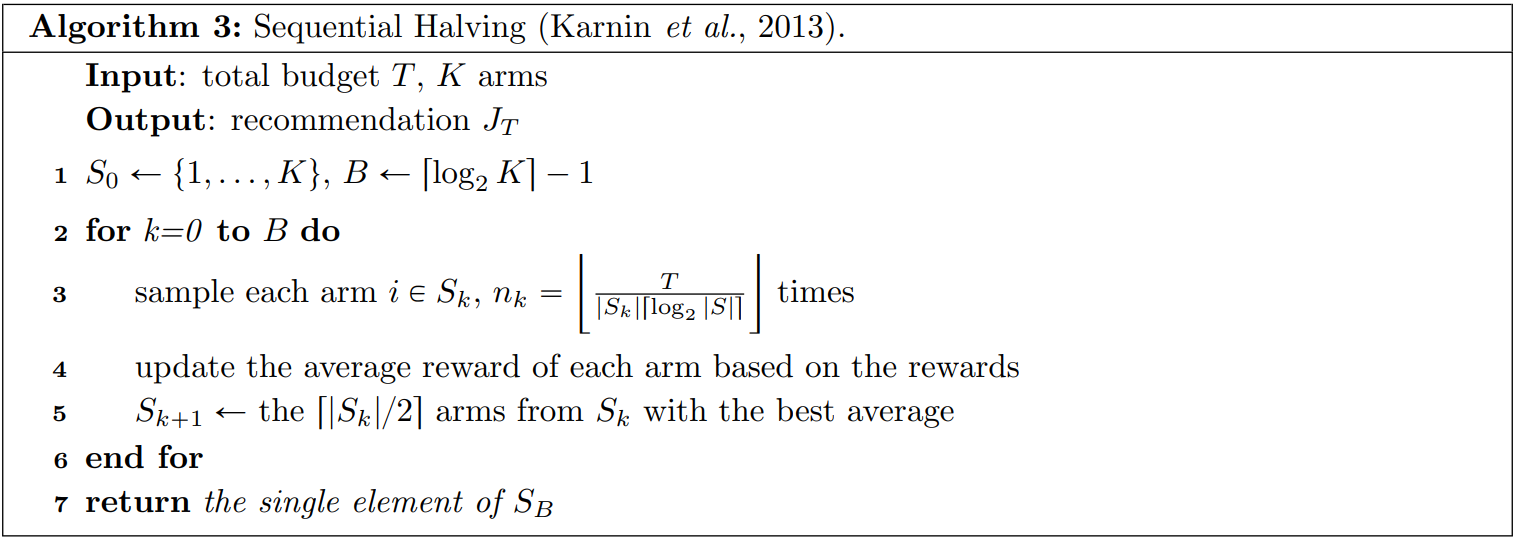

In [5]:

import math


class SequentialHalvingAlg:
  """
  Baseline sequential halving algorithm using a discrete iteration budget (as per Karnin et al., 2013).
  """
  
  rounds = math.ceil(math.log2(k)) - 1 #Amount of rounds to be used in the algorithm/amount of times the amount of considered arms will be halved
  
  def __init__(self,return_hist=False):
      self.current_arms = range(k) #A list of all arms that the algorithm cares about. Will be sequentially halved ;)
      self.current_arm = self.current_arms[0] #Keeping track of the current arm to pull
      self.current_rewards = [0] * k #The rewards that the algorithm has observed for each arm
      self.visits = [0] * k #The amount of times that the algorithm has pulled each arm
      self.total_rewards = [0] * k #The total rewards that the algorithm has observed for each arm
      self.considered_arms_amt = k #The amount of arms that the algorithm is currently considering
      self.sample_count_per_arm = self.get_dist_per_arm(k) #Amount of times by which each arm should be sampled (as per Karnin et al algorithm).
      self.current_iteration = 0 
      self.budget_left = time_steps_per_problem
      self.current_round = 1
      self.return_hist = return_hist
      self.hist = [] #Stores history of arms pulled

  
  
  """
  Retruns the amount of budget to be allocated to each arm.
  """
  def get_dist_per_arm(self, num_arms):
      return math.floor(time_steps_per_problem/(num_arms*math.ceil(math.log2(num_arms))))
    
  
  def reset(self) -> None:
    self.current_arms = range(k)
    self.current_arm = self.current_arms[0]
    self.current_rewards = [0] * k
    self.visits = [0] * k 
    self.total_rewards = [0] * k 
    self.considered_arms_amt = k
    self.sample_count_per_arm = self.get_dist_per_arm(k)
    self.budget_left = time_steps_per_problem
    self.current_round = 1
    self.hist = [] #Stores history of arms pulled
    self.budget_left = time_steps_per_problem
  

  def choose_arm(self) -> int:
    #print(f"current_arm: {self.current_arm} current index: {self.current_arms.index(self.current_arm)} current_iteration: {self.current_iteration} considered_arms_amt: {self.considered_arms_amt} current_round: {self.current_round} budget_left: {self.budget_left} sample_count_per_arm: {self.sample_count_per_arm} arms left: {len(self.current_arms)}")
    if(self.considered_arms_amt < 1): return self.current_arm
    
    
    if self.current_iteration == self.sample_count_per_arm:
      self.current_iteration = 0
      
      
      #Check to see if we have used every arm the amount of times we should have
      if self.current_arms.index(self.current_arm) + 1 == self.considered_arms_amt:
        #If we have, we halve the amount of considered arms based on rewards and reset the current arm to the first arm in the list
        
        # Pair each arm with its corresponding reward, sort the pairs, and extract the arms
        self.current_arms, self.current_rewards = zip(*sorted(zip(self.current_arms, self.current_rewards), key=lambda x: x[1], reverse=True))
        self.current_arms = list(self.current_arms)
        self.current_rewards = list(self.current_rewards)
        
        
        self.current_arms = self.current_arms[:math.ceil(self.considered_arms_amt/2)] #Take top half of the list
        self.current_rewards = self.current_rewards[:math.ceil(self.considered_arms_amt/2)]
        self.considered_arms_amt = len(self.current_arms)
        # self.considered_arms_amt = math.ceil(self.considered_arms_amt/2)
        self.current_round = self.current_round + 1
        
        self.budget_left = self.budget_left/2 #FIXME: Is this correct or should it be rounded up before use in the halving method?
        
        # budget_left = self.budget_left
        if self.considered_arms_amt == 1:
          self.sample_count_per_arm = self.budget_left
        else:
          self.sample_count_per_arm = self.get_dist_per_arm(self.considered_arms_amt)
          
        self.current_arm = self.current_arms[0]
        
        if self.return_hist: self.hist.append(self.current_arm)
        
        return self.current_arm
      
     
      self.current_arm = self.current_arms[self.current_arms.index(self.current_arm)+1]
      
      if self.return_hist: self.hist.append(self.current_arm)
      return self.current_arm
    else:
      self.current_iteration = self.current_iteration + 1
      if self.return_hist: self.hist.append(self.current_arm)
      return self.current_arm

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    
    """
    self.visits[self.current_arms.index(arm)] = self.visits[self.current_arms.index(arm)] + 1
    self.total_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)] + reward
    self.current_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)]/self.visits[self.current_arms.index(arm)]
    
    

  def __str__(self):
    return print(f"Sequential_halving:\nArm history: {self.hist}\n")

In [6]:
seq_h = SequentialHalvingAlg(True)
# for n in range(time_steps_per_problem):
#   seq_h.choose_arm()
  
rewards = np.zeros(time_steps_per_problem)
for t in range(time_steps_per_problem):
    arm = seq_h.choose_arm()

    reward = norm.rvs(loc=arm_means[0,:][arm], scale=1.0)

    seq_h.observe_reward(arm, reward)
    rewards[t] = reward  
  
history = seq_h.hist
seq_h.reset()


### Distribution of Arms Visited During Iteration Budget Sequential Halving 

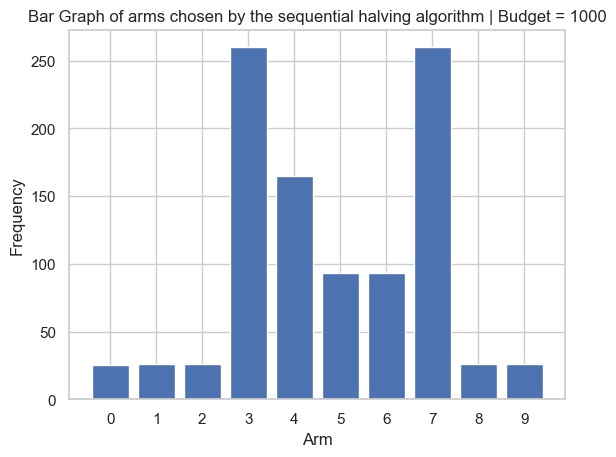

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 

In [7]:
#Histogram of the distribution of arms chosen by the sequential halving algorithm
plt.bar(range(k), [history.count(i) for i in range(k)])
plt.xlabel('Arm')
plt.ylabel('Frequency')
plt.title('Bar Graph of arms chosen by the sequential halving algorithm | Budget = 1000')
plt.xticks(range(k))
plt.show()

print(history)
print(arm_means[0,:])

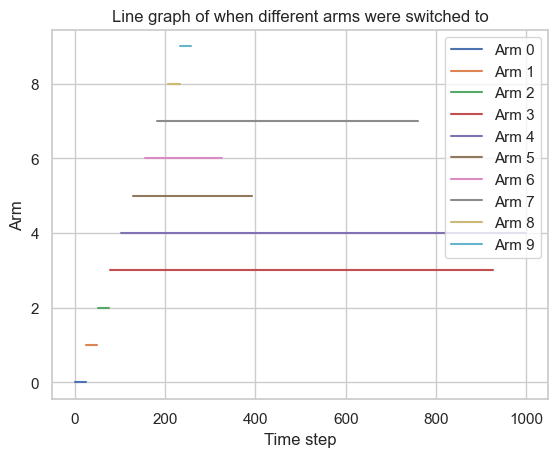

In [8]:
# Create an array of the same length as history with the index as values
indices = np.arange(len(history))

# Create a line graph
for arm in range(k):
    # Get the indices where this arm was chosen
    arm_indices = [i for i, x in enumerate(history) if x == arm]
    # Get the corresponding values from history
    arm_values = [history[i] for i in arm_indices]
    plt.plot(arm_indices, arm_values, label=f'Arm {arm}')

plt.xlabel('Time step')
plt.ylabel('Arm')
plt.title('Line graph of when different arms were switched to')
plt.legend()
plt.show()

## Time-based Sequential Halving Algorithm

In [9]:
import math
import time


class SequentialHalvingAlgTime_v1:
  """
  Baseline sequential halving algorithm using a time based budget (inspired by Karnin et al., 2013).
  """
  
  rounds = math.ceil(math.log2(k)) - 1 #Amount of rounds to be used in the algorithm/amount of times the amount of considered arms will be halved
  
  def __init__(self, time_budget, return_hist=False):
      self.current_arms = range(k) #A list of all arms that the algorithm cares about. Will be sequentially halved ;)
      self.current_arm = self.current_arms[0] #Keeping track of the current arm to pull
      self.current_rewards = [0] * k #The rewards that the algorithm has observed for each arm
      self.visits = [0] * k #The amount of times that the algorithm has pulled each arm
      self.total_rewards = [0] * k #The total rewards that the algorithm has observed for each arm
      self.considered_arms_amt = k #The amount of arms that the algorithm is currently considering
      
      self.time_budget = time_budget
      self.sample_count_per_arm = self.get_dist_per_arm(k) #Amount of times by which each arm should be sampled (as per Karnin et al algorithm).
      self.current_iteration = 0 
      
      self.budget_left = time_budget
      self.current_round = 1
      self.return_hist = return_hist
      self.hist = [] #Stores history of arms pulled
      self.current_time = int(round(time.time() * 1000))
      self.prev_switch_time = self.current_time
      self.start_time = self.current_time

  
  
  """
  Retruns the amount of time to be allocated to each arm.
  """
  def get_dist_per_arm(self, num_arms):
      return math.floor(self.time_budget/(num_arms*math.ceil(math.log2(num_arms))))
    
  
  def reset(self) -> None:
    self.current_arms = range(k)
    self.current_arm = self.current_arms[0]
    self.current_rewards = [0] * k
    self.visits = [0] * k 
    self.total_rewards = [0] * k 
    self.considered_arms_amt = k
    self.sample_count_per_arm = self.get_dist_per_arm(k)
    self.budget_left = time_steps_per_problem
    self.current_round = 1
    self.hist = [] #Stores history of arms pulled
    self.budget_left = time_steps_per_problem
    self.current_time = int(round(time.time() * 1000))
  

  def choose_arm(self) -> int:
    print(f"current_arm: {self.current_arm} current index: {self.current_arms.index(self.current_arm)} current_iteration: {self.current_iteration} considered_arms_amt: {self.considered_arms_amt} current_round: {self.current_round} budget_left: {self.budget_left} sample_count_per_arm: {self.sample_count_per_arm} arms left: {len(self.current_arms)}")
    self.current_time = int(round(time.time() * 1000))
    
    if(self.considered_arms_amt < 1): return self.current_arm
    
    
    if self.current_time - self.prev_switch_time <= self.sample_count_per_arm:
      
      
      #Check to see if we have used every arm the amount of times we should have
      #print(f"current_arms.index(self.current_arm): {self.current_arms.index(self.current_arm)}, considered_arms_amt: {self.considered_arms_amt}")
      if self.current_arms.index(self.current_arm) + 1 == self.considered_arms_amt:
        #If we have, we halve the amount of considered arms based on rewards and reset the current arm to the first arm in the list
        
        # Pair each arm with its corresponding reward, sort the pairs, and extract the arms
        self.current_arms, self.current_rewards = zip(*sorted(zip(self.current_arms, self.current_rewards), key=lambda x: x[1], reverse=True))
        self.current_arms = list(self.current_arms)
        self.current_rewards = list(self.current_rewards)
        
        
        self.current_arms = self.current_arms[:math.ceil(self.considered_arms_amt/2)] #Take top half of the list
        self.current_rewards = self.current_rewards[:math.ceil(self.considered_arms_amt/2)]
        self.considered_arms_amt = len(self.current_arms)
        self.current_round = self.current_round + 1
        
        self.budget_left = self.budget_left/2 #FIXME: Is this correct or should it be rounded up before use in the halving method?
        
        if self.considered_arms_amt == 1:
          self.sample_count_per_arm = self.budget_left
        else:
          self.sample_count_per_arm = self.get_dist_per_arm(self.considered_arms_amt)
          
        self.current_arm = self.current_arms[0]
        
        if self.return_hist: self.hist.append(self.current_arm)
        
        return self.current_arm
      
      
      self.current_arm = self.current_arms[self.current_arms.index(self.current_arm) + 1]
      self.prev_switch_time = int(round(time.time() * 1000))
      
      
      if self.return_hist: self.hist.append(self.current_arm)
      
      return self.current_arm
    else:
      self.current_time = int(round(time.time() * 1000))
      
      if self.return_hist: self.hist.append(self.current_arm)
      return self.current_arm

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    
    """
    self.visits[self.current_arms.index(arm)] = self.visits[self.current_arms.index(arm)] + 1
    self.total_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)] + reward
    self.current_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)]/self.visits[self.current_arms.index(arm)]
    
    

  def __str__(self):
    return print(f"Sequential_halving:\nArm history: {self.hist}\n")

In [10]:


# for n in range(time_steps_per_problem):
#   seq_h.choose_arm()
  
rewards = []
time_budget = 3000 #milliseconds
seq_h_t = SequentialHalvingAlgTime_v1(time_budget, True)

start_time = int(round(time.time() * 1000))
while int(round(time.time() * 1000)) - start_time < time_budget:
    arm = seq_h_t.choose_arm()

    reward = norm.rvs(loc=arm_means[0,:][arm], scale=1.0)

    seq_h_t.observe_reward(arm, reward)
    rewards.append(reward)  
    time.sleep(0.01) #might not be needed but notebook freaks out if i dont have it
  
history = seq_h_t.hist
print(history)
seq_h_t.reset()

current_arm: 0 current index: 0 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 1 current index: 1 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 2 current index: 2 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 3 current index: 3 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 4 current index: 4 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 5 current index: 5 current_iteration: 0 considered_arms_amt: 10 current_round: 1 budget_left: 3000 sample_count_per_arm: 75 arms left: 10
current_arm: 6 current index: 6 current_iteration: 0 considered_arms_amt: 10 current_round: 1 

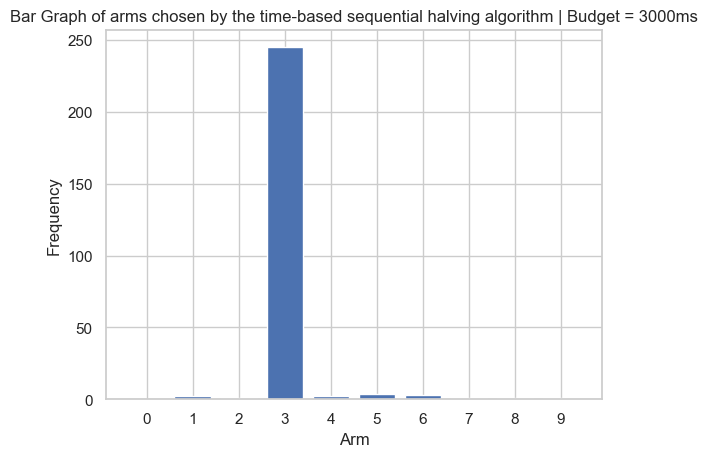

[1, 2, 3, 4, 5, 6, 7, 8, 9, 4, 6, 1, 3, 5, 6, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[-0.72301836  0.01945132 -0.89764625  0.4136809   0.7839224   0.18304446
  0.68123548  0.7104487  -1.20591124  0.18870388]


In [11]:
#Histogram of the distribution of arms chosen by the sequential halving algorithm
plt.bar(range(k), [history.count(i) for i in range(k)])
plt.xlabel('Arm')
plt.ylabel('Frequency')
plt.title(f'Bar Graph of arms chosen by the time-based sequential halving algorithm | Budget = {time_budget}ms')
plt.xticks(range(k))
plt.show()

print(history)
print(arm_means[0,:])

****

# Tutorial Notebook Section

## First Experiment: Evaluating the Random Algorithm
As a first experiment, we will evaluate the performance (in terms of rewards) of the Random algorithm.

Evaluating Random algorithm:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating Random algorithm: 100%|██████████| 200/200 [00:12<00:00, 15.54it/s]


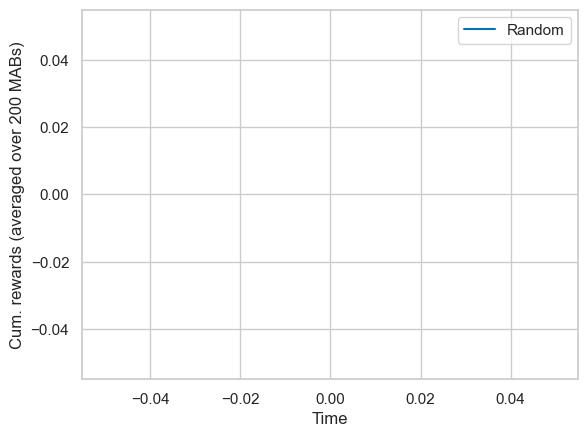

In [12]:
# Allocate memory to store rewards collected for all MAB problems
rewards_matrix = np.zeros(shape=(num_mab_problems, time_steps_per_problem))

# Loop through all our MAB problems
for problem in tqdm(range(num_mab_problems), desc="Evaluating Random algorithm"):
  # Run a simulation with the Random algorithm in this problem
  rewards_matrix[problem, :] = run_simulation(algorithm=RandomAlg(), true_arm_means=arm_means[problem, :], n=time_steps_per_problem)

# Create a plot of the cumulative rewards we collected over time, averaged over all MAB problems
cumulative_rewards_per_prob = np.cumsum(rewards_matrix, axis=1, dtype=np.float64)

palette = itertools.cycle(sns.color_palette('colorblind'))
fig, ax = plt.subplots()
plt.plot([t for t in range(time_steps_per_problem)], np.mean(cumulative_rewards_per_prob, axis=0), label="Random", color=next(palette))
ax.set_xlabel("Time")
ax.set_ylabel(f"Cum. rewards (averaged over {num_mab_problems} MABs)")
ax.legend()

## Implementing More Algorithms

Here, we'll finally start implementing some more advanced algorithms. This is where you'll have to add your own implementations. Every time after you have implemented one algorithm, you can skip to the [Evaluating Stochastic MAB Algorithms](#evaluating-stochastic-mab-algorithms) section down below and add your new algorithm to the list of algorithms that we evaluate.

In [13]:
class ExploreThenCommit:
  """
  The explore-then-commit (ETC) algorithm. It should first try every
  arm m times (for some m >= 1), and afterwards always greedly pull
  whichever arm performed best on average during the initial
  exploration phase.
  """

  def __init__(self, m: int):
    """
    :param m: Number of times we want to explore every arm.
    """
    self.m = m
    # TODO: init any other variables for memory you may need here

  def reset(self) -> None:
    """
    Reset all memory.
    """
    # TODO: provide implementation

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k).
    """
    # TODO: provide implementation

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    # TODO: provide implementation

  def __str__(self):
    return f"ETC({self.m})"

In [14]:
class EpsilonGreedy:
  """
  The epsilon-greedy algorithm.
  """

  def __init__(self, epsilon: float):
    """
    :param epsilon: The epsilon parameter (probability of selecting random arm).
    """
    self.epsilon = epsilon
    # TODO: init any other variables for memory you may need here

  def reset(self) -> None:
    """
    Reset all memory.
    """
    # TODO: provide implementation

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k).
    """
    # TODO: provide implementation

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    # TODO: provide implementation

  def __str__(self):
    return f"eps-greedy({self.epsilon:.3f})"

In [15]:
class UCB1:
  """
  The UCB1 algorithm.
  """

  def __init__(self, C: float):
    """
    :param C: The exploration parameter C.
    """
    self.C = C
    # TODO: init any other variables for memory you may need here

  def reset(self) -> None:
    """
    Reset all memory.
    """
    # TODO: provide implementation

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k).
    """
    # TODO: provide implementation

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    # TODO: provide implementation

  def __str__(self):
    return f"UCB1({self.C:.3f})"

In [16]:
class GradientBandit:
  """
  The Stochastic Gradient Bandit algorithm.
  """

  def __init__(self, alpha: float):
    """
    :param alpha: The learning rate alpha.
    """
    self.alpha = alpha
    # TODO: init any other variables for memory you may need here

  def reset(self) -> None:
    """
    Reset all memory.
    """
    # TODO: provide implementation

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k).
    """
    # TODO: provide implementation

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    # TODO: provide implementation

  def __str__(self):
    return f"Gradient Bandit({self.alpha:.3f})"

In [17]:
class GradientBanditBaseline:
  """
  The Stochastic Gradient Bandit algorithm, with baseline.
  """

  def __init__(self, alpha: float):
    """
    :param alpha: The learning rate alpha.
    """
    self.alpha = alpha
    # TODO: init any other variables for memory you may need here

  def reset(self) -> None:
    """
    Reset all memory.
    """
    # TODO: provide implementation

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k).
    """
    # TODO: provide implementation

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    # TODO: provide implementation

  def __str__(self):
    return f"Gradient Bandit with Baseline({self.alpha:.3f})"

<a name="evaluating-stochastic-mab-algorithms"></a>
## Evaluating Stochastic MAB Algorithms

This time we'll not just evaluate the Random algorithm, but also evaluate any new algorithms we've implemented. We'll also add a second type of plot: one that shows the average reward

Evaluating Random:   2%|▏         | 4/200 [00:00<00:12, 15.33it/s]

Evaluating Random: 100%|██████████| 200/200 [00:10<00:00, 18.42it/s]


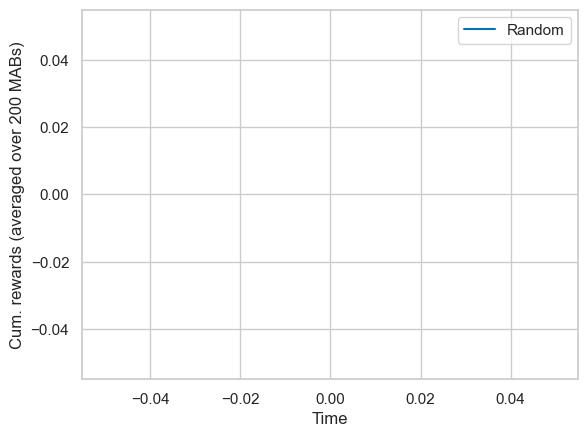

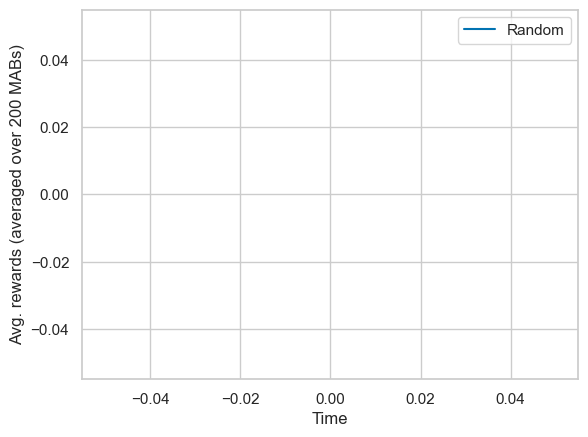

In [18]:
# List of all the algorithms we want to evaluate
algorithms = [
    RandomAlg(),

    # Uncomment once you've implemented this algorithm:
    #ExploreThenCommit(m=10),

    # Uncomment once you've implemented this algorithm:
    #EpsilonGreedy(epsilon=0.1),

    # Uncomment once you've implemented this algorithm:
    #UCB1(C=sqrt(2.0)),

    # Uncomment once you've implemented this algorithm:
    #GradientBandit(alpha=0.1),

    # Uncomment once you've implemented this algorithm:
    #GradientBanditBaseline(alpha=0.1),
]

# Define a function that creates evaluation plots for a list of algorithms.
def create_eval_plots_for_algs(algorithms):
  # Prepare figures
  palette = itertools.cycle(sns.color_palette('colorblind'))
  linestyles = itertools.cycle(["-", "--", ":"])
  fig_cumsums, ax_cumsums = plt.subplots()
  fig_avgs, ax_avgs = plt.subplots()

  # For every algorithm, run simulation and add plot
  for algorithm in algorithms:
    color = next(palette)
    linestyle = next(linestyles)

    # Allocate memory to store rewards collected for all MAB problems
    rewards_matrix = np.zeros(shape=(num_mab_problems, time_steps_per_problem))

    # Loop through all our MAB problems
    for problem in tqdm(range(num_mab_problems), desc="Evaluating " + algorithm.__str__()):
      # Run a simulation with the Random algorithm in this problem
      rewards_matrix[problem, :] = run_simulation(algorithm=algorithm, true_arm_means=arm_means[problem, :], n=time_steps_per_problem)

    # Create a plot of the cumulative rewards we collected over time, averaged over all MAB problems
    cumulative_rewards_per_prob = np.cumsum(rewards_matrix, axis=1, dtype=np.float64)
    ax_cumsums.plot([t for t in range(time_steps_per_problem)], np.mean(cumulative_rewards_per_prob, axis=0),
                    label=algorithm.__str__(), color=color, linestyle=linestyle)

    # Create a plot of the average (over all timesteps so far) rewards collected per time step, averaged over all MAB problems
    cumulative_means_per_prob = cumulative_rewards_per_prob / np.arange(1, time_steps_per_problem + 1)
    ax_avgs.plot([t for t in range(time_steps_per_problem)], np.mean(cumulative_means_per_prob, axis=0),
                label=algorithm.__str__(), color=color, linestyle=linestyle)

  # Finish figures
  ax_cumsums.set_xlabel("Time")
  ax_cumsums.set_ylabel(f"Cum. rewards (averaged over {num_mab_problems} MABs)")
  ax_cumsums.legend()

  ax_avgs.set_xlabel("Time")
  ax_avgs.set_ylabel(f"Avg. rewards (averaged over {num_mab_problems} MABs)")
  ax_avgs.legend()

# Call the function we just defined
create_eval_plots_for_algs(algorithms)

## Evaluating Hyperparameters: ETC

Let's evaluate ETC with different values for its hyperparameter.

Evaluating ETC(1):   0%|          | 0/200 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence.

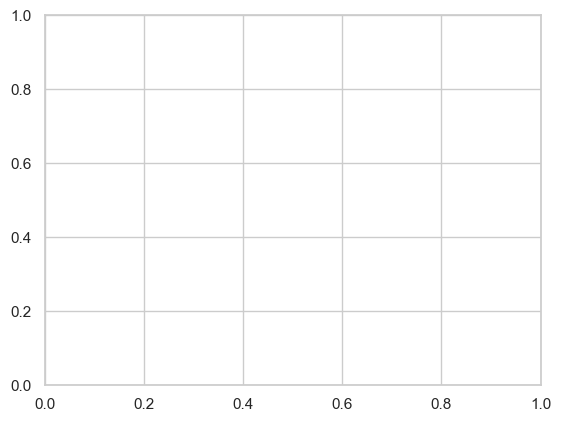

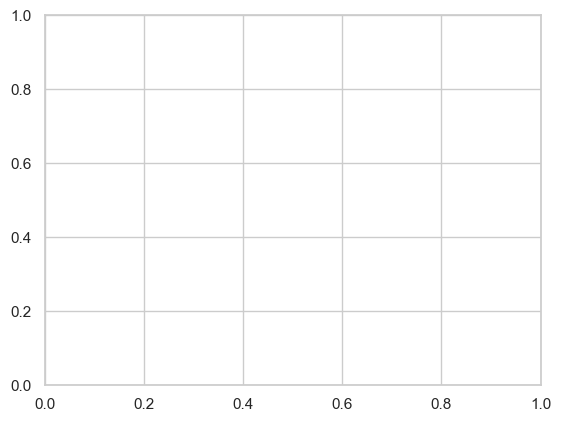

In [19]:
# List of all the algorithms we want to evaluate
etc_algorithms = [
    ExploreThenCommit(m=1),
    ExploreThenCommit(m=2),
    ExploreThenCommit(m=5),
    ExploreThenCommit(m=10),
    ExploreThenCommit(m=20),
]

create_eval_plots_for_algs(etc_algorithms)

## Evaluating Hyperparameters: $\epsilon$-greedy

Let's evaluate $\epsilon$-greedy with different values for its hyperparameter.

In [ ]:
# List of all the algorithms we want to evaluate
eps_greedy_algorithms = [
    EpsilonGreedy(epsilon=0.0),
    EpsilonGreedy(epsilon=0.05),
    EpsilonGreedy(epsilon=0.1),
    EpsilonGreedy(epsilon=0.15),
    EpsilonGreedy(epsilon=0.2),
]

create_eval_plots_for_algs(eps_greedy_algorithms)

## Evaluating Hyperparameters: UCB1

Let's evaluate UCB1 with different values for its hyperparameter.

In [ ]:
# List of all the algorithms we want to evaluate
ucb1_algorithms = [
    UCB1(C=0.0),
    UCB1(C=0.1),
    UCB1(C=0.6),
    UCB1(C=1.0),
    UCB1(C=sqrt(2.0)),
    UCB1(C=2.0),
]

create_eval_plots_for_algs(ucb1_algorithms)

## Evaluating Hyperparameters: Gradient Bandit

Let's evaluate Gradient Bandit with different values for its hyperparameter.

In [ ]:
# List of all the algorithms we want to evaluate
gradient_bandit_algorithms = [
    GradientBandit(alpha=0.01),
    GradientBandit(alpha=0.05),
    GradientBandit(alpha=0.1),
    GradientBandit(alpha=0.2),
    GradientBandit(alpha=0.5),
]

create_eval_plots_for_algs(gradient_bandit_algorithms)